# INTRODUCTION: MODEL 1

**Model** that is used to map steady-state speed to throttle is given as follows:

$\displaystyle{ \hat{u}_s = \beta_1 \left(1 - e^{\beta_2 (v_s - \beta_3)} \right), \; \hat{u}_s \geq 0 }$

where $u_s$ is throttle, $v_s$ is steady-state speed given constant input, and $\beta_1, \beta_2, \beta_3 \in \Re$

The **optimization formulation** is given by:

$ \displaystyle{
J = \frac{1}{2m} \sum_{i=1}^m \left[u_s - \hat{u}_s \right]^2
} $

In this section, **flower pollination algorithm** (FPA) will be used to minimize the cost function $J$. The constraint is described as follows:

$ \displaystyle{
    \beta_1, \beta_3 \geq 0
} $

$\displaystyle{
\beta_2 \leq 0
}$

# IMPORT LIBRARY AND DATA

In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import njit, prange
from os import listdir
from os.path import isfile, join

%matplotlib inline
plt.style.use(['science','ieee'])

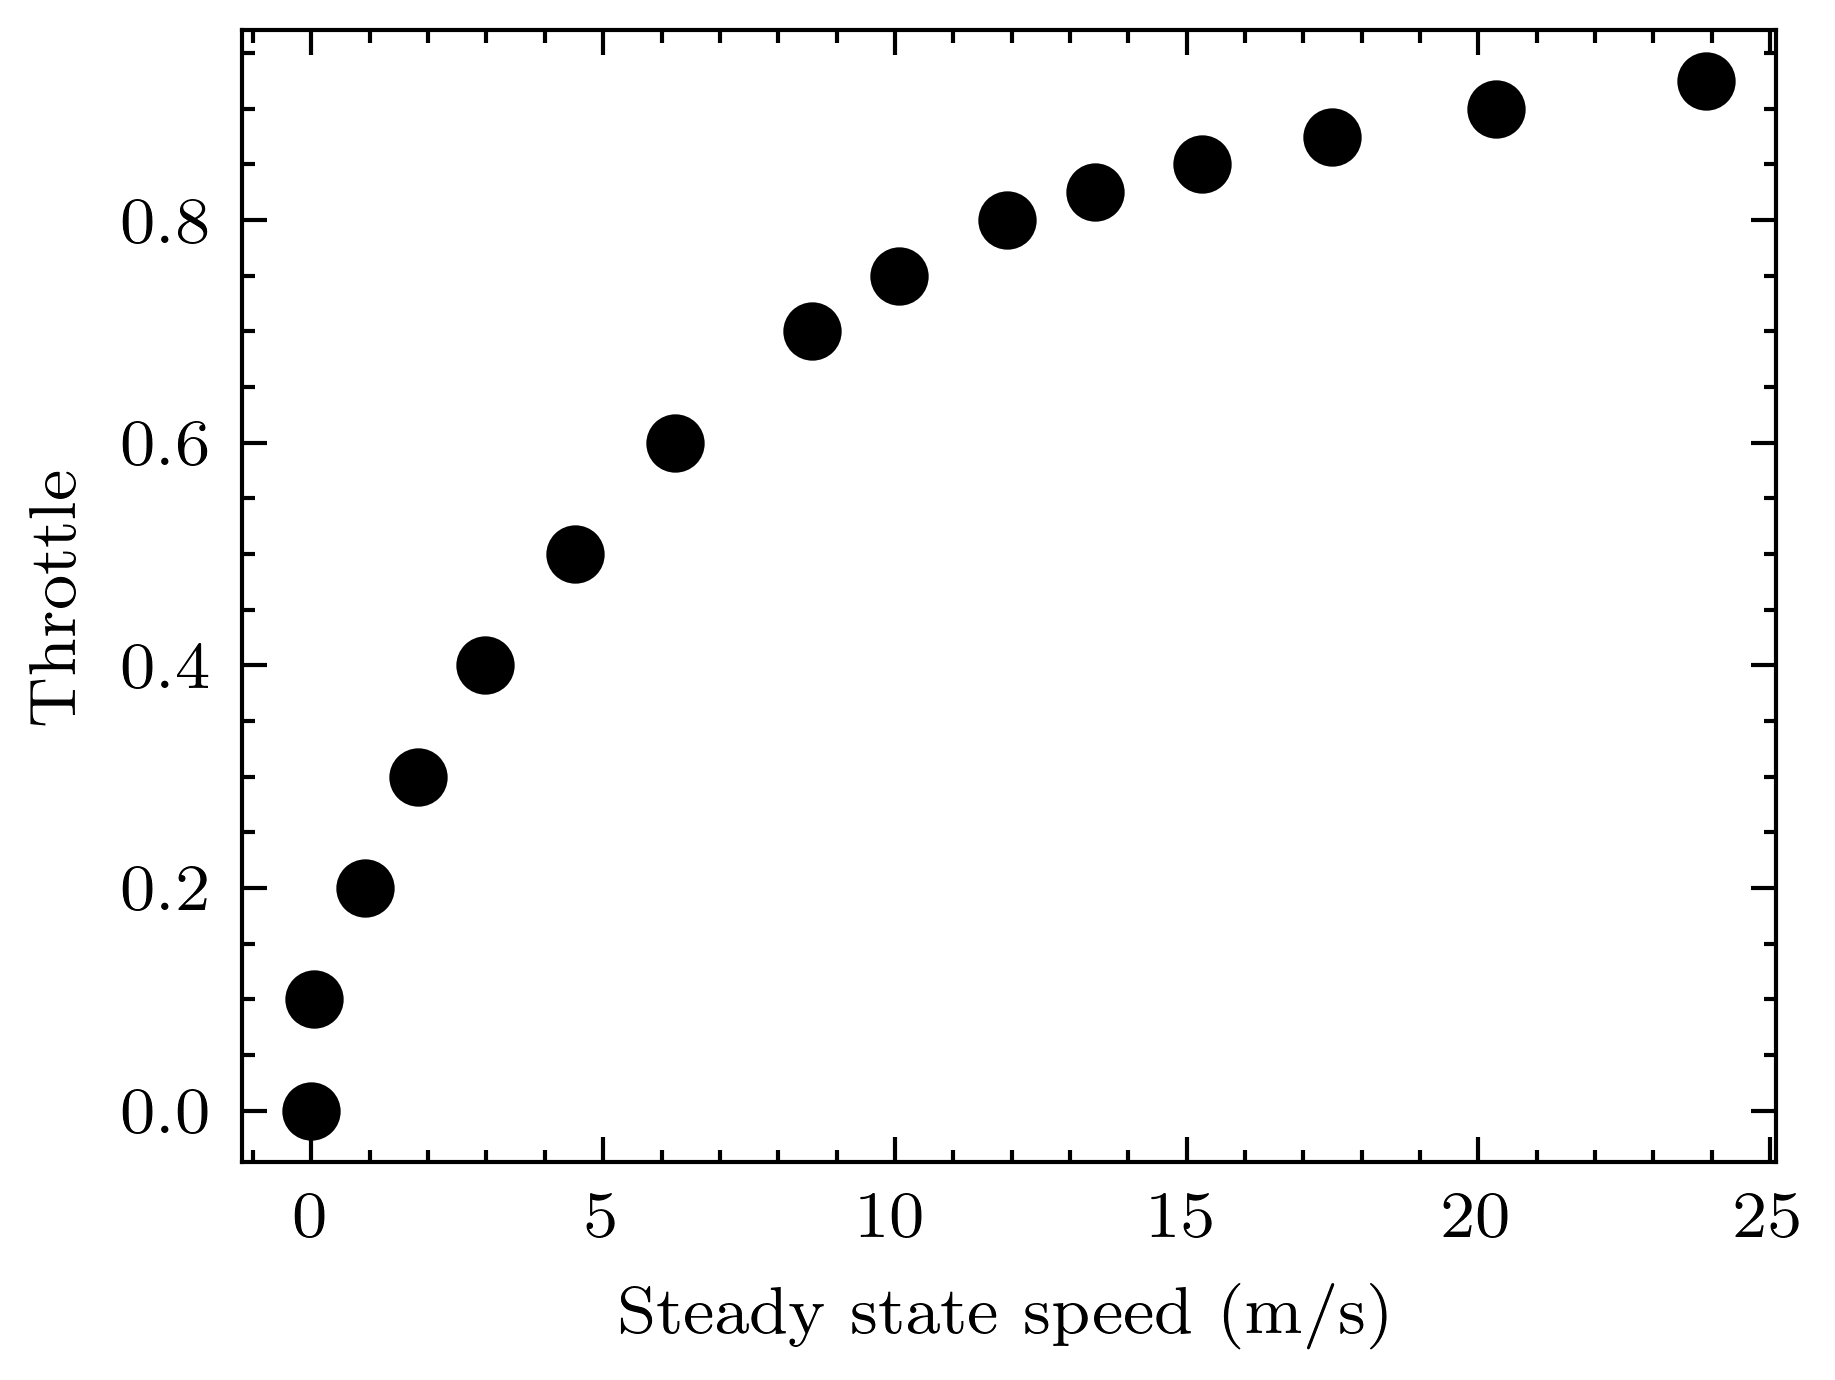

In [2]:
df = pd.read_csv('../steady_state_response.csv')
v = np.array(df.ssv)
u = np.array(df.u)


plt.figure()
plt.scatter(v, u)
plt.xlabel('Steady state speed (m/s)')
plt.ylabel('Throttle')
plt.show()

# MAKE FUNCTION

## Generate population

In [3]:
def generate_population(num, dim, rng):
    """
    Generate population:
        Input:
            num: number of population (integer)
            dim: number of parameters (integer)
            rng: range number used in initialization (list or numpy array)
        Output:
            pop: initial position of the population (numpy array)
    """
    pop = np.zeros((num,dim))
    for i in range(dim):
        lim = rng[i]
        pop[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return pop

## Constraint

In [4]:
@njit
def admissible(param):
    b1, b2, b3 = param
    if b1 < 0. or b2 > 0. or b3 < 0.:
        return False
    else:
        return True
_ = admissible(np.random.randn(3))

## Forward propagation

In [5]:
@njit
def forward_propagation(u, param):
    b1, b2, b3 = param
    
    out = b1 * (1 - np.exp(b2*(u))) + b3
    out = np.fmax(out, 0.)
    
    # When the vehicle is not moving
    out[u <= 1e-2] = 0.
    
    return out

_ = forward_propagation(np.array([0.0, 0.1]), np.ones(3)*0.5)

## Cost and metric

In [6]:
@njit
def cost(u, v, param):
    error = v - forward_propagation(u, param)
    cost = np.mean(error**2)
    return cost
_ = cost(v, u, np.ones(3)*0.5)

In [7]:
@njit
def calculate_total_cost(param):    
    if admissible(param):
        loss = cost(v, u, param)
    else:
        loss = np.Inf
    return loss
_ = calculate_total_cost(np.ones(3)*0.5)

In [8]:
@njit(parallel=True)
def population_cost(population):
    length = population.shape[0]
    losses = np.zeros(length)
    for ii in prange(length):
        losses[ii] = calculate_total_cost(population[ii])
    return losses
_ = population_cost(np.random.randn(2,3))

## PSO

In [9]:
@njit
def pso(population, loss_population, global_, global_loss, w, c1, c2):
    num = population.shape[0]
    dim = population.shape[1]
    
    # Initial conditions
    ppos_vector = np.copy(population)
    pbest_pos = np.copy(ppos_vector)
    pfit_value = np.copy(loss_population)
    gbest_pos = np.copy(global_)
    gfit_value = global_loss
    pvel_vector = np.zeros((num, dim))
    
    for i in range(num):
        # Update the velocity and position vector
        pvel_vector[i] = w*pvel_vector[i] + c1*np.random.random()*(pbest_pos[i]-ppos_vector[i]) + c2*np.random.random()*(gbest_pos-ppos_vector[i])
        ppos_vector[i] = pvel_vector[i] + ppos_vector[i]
        
        cost_func = calculate_total_cost(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
    
    return pbest_pos, pfit_value, gbest_pos, gfit_value
    
xx1 = np.ones((2, 3))*1.0
xx2 = np.ones(2)
xx3 = np.ones(3)*0.5
_ = pso(xx1, xx2, xx3, 100.0, 0.8, 1.5, 0.1)

# SIMULATION

In [10]:
num = 25
n_sim = 50
n_itr = 5000

r_b1 = [0.,  2.]
r_b2 = [0., -2.]
r_b3 = [0.,  2.]

rng = [r_b1, r_b2, r_b3]
dim = len(rng)

w = 0.5
c1 = 0.7
c2 = 0.8

param_history = np.zeros((n_sim, dim))
loss_history = np.ones(n_sim)*np.Inf

the_best_param_history = np.zeros((n_itr, dim))
the_best_loss_history = np.zeros(n_itr)

for j in range(n_sim):
    population = generate_population(num, dim, rng)
    global_ = None
    global_loss_ = np.Inf
    
    loss_population = population_cost(population)
    loss_population[np.isnan(loss_population)] = np.Inf
    min_idx = np.argmin(loss_population)
    min_loss = loss_population[min_idx]
    if global_loss_ > min_loss:
        global_loss_ = min_loss
        global_ = np.copy(population[min_idx, :])
        
    global_history = np.empty((n_itr, dim))
    global_history[0] = global_
    global_loss_history = np.empty(n_itr)
    global_loss_history[0] = global_loss_
    for i in range(1, n_itr):
        # Particle Swarm Optimization
        population, loss_population, global_, global_loss_ = pso(population, loss_population, global_, global_loss_, w, c1, c2)
        
        global_history[i] = global_
        global_loss_history[i] = global_loss_
    
    if np.min(loss_history) > global_loss_history[-1]:
        the_best_loss_history = np.copy(global_loss_history)
        the_best_param_history = np.copy(global_history)
        
    param_history[j] = np.copy(global_history[-1])
    loss_history[j] = np.copy(global_loss_history[-1])
    
    print('simulation: {} || global loss: {:.10f} || the best loss: {:.10f}'.format(j, global_loss_history[-1], the_best_loss_history[-1]))

simulation: 0 || global loss: 0.0725007144 || the best loss: 0.0725007144
simulation: 1 || global loss: 0.0593492800 || the best loss: 0.0593492800
simulation: 2 || global loss: 0.0074447106 || the best loss: 0.0074447106
simulation: 3 || global loss: 0.0343124527 || the best loss: 0.0074447106
simulation: 4 || global loss: 0.0197107688 || the best loss: 0.0074447106
simulation: 5 || global loss: 0.0004296251 || the best loss: 0.0004296251
simulation: 6 || global loss: 0.0255721932 || the best loss: 0.0004296251
simulation: 7 || global loss: 0.0264493912 || the best loss: 0.0004296251
simulation: 8 || global loss: 0.0367570794 || the best loss: 0.0004296251
simulation: 9 || global loss: 0.1438815206 || the best loss: 0.0004296251
simulation: 10 || global loss: 0.0199333387 || the best loss: 0.0004296251
simulation: 11 || global loss: 0.0398717258 || the best loss: 0.0004296251
simulation: 12 || global loss: 0.0364169738 || the best loss: 0.0004296251
simulation: 13 || global loss: 0.05

In [11]:
# Save the simulation
np.save('result/param_history.npy', param_history)
np.save('result/loss_history.npy', loss_history)
np.save('result/the_best_loss_history.npy', the_best_loss_history)
np.save('result/the_best_param_history.npy', the_best_param_history)

f = open("result/sim.cfg", "w+")
f.writelines('num: {} # The number of flowers\n'.format(num))
f.writelines('n_sim: {} # The number of simulation loop\n'.format(n_sim))
f.writelines('n_itr: {} # The number of iteration for each simulation\n'.format(n_itr))
f.writelines('\n# The boundary of the initialization value\n')
f.writelines('r_b1: {}\n'.format(r_b1))
f.writelines('r_b2: {}\n'.format(r_b2))
f.writelines('r_b3: {}\n'.format(r_b3))
f.writelines('\n# The PSO hyperparameters\n')
f.writelines('w: {}\n'.format(w))
f.writelines('c1: {}\n'.format(c1))
f.writelines('c2: {}\n'.format(c2))
f.close()

# RESULT

In [12]:
# Load the model
the_best_param_history = np.load('result/the_best_param_history.npy')
the_best_loss_history = np.load('result/the_best_loss_history.npy')

In [13]:
print('Minimum Cost: {}'.format(the_best_loss_history[-1]))
print('Parameters:')
print(the_best_param_history[-1])

Minimum Cost: 0.0002855790827961455
Parameters:
[ 0.85942426 -0.172867    0.05926047]


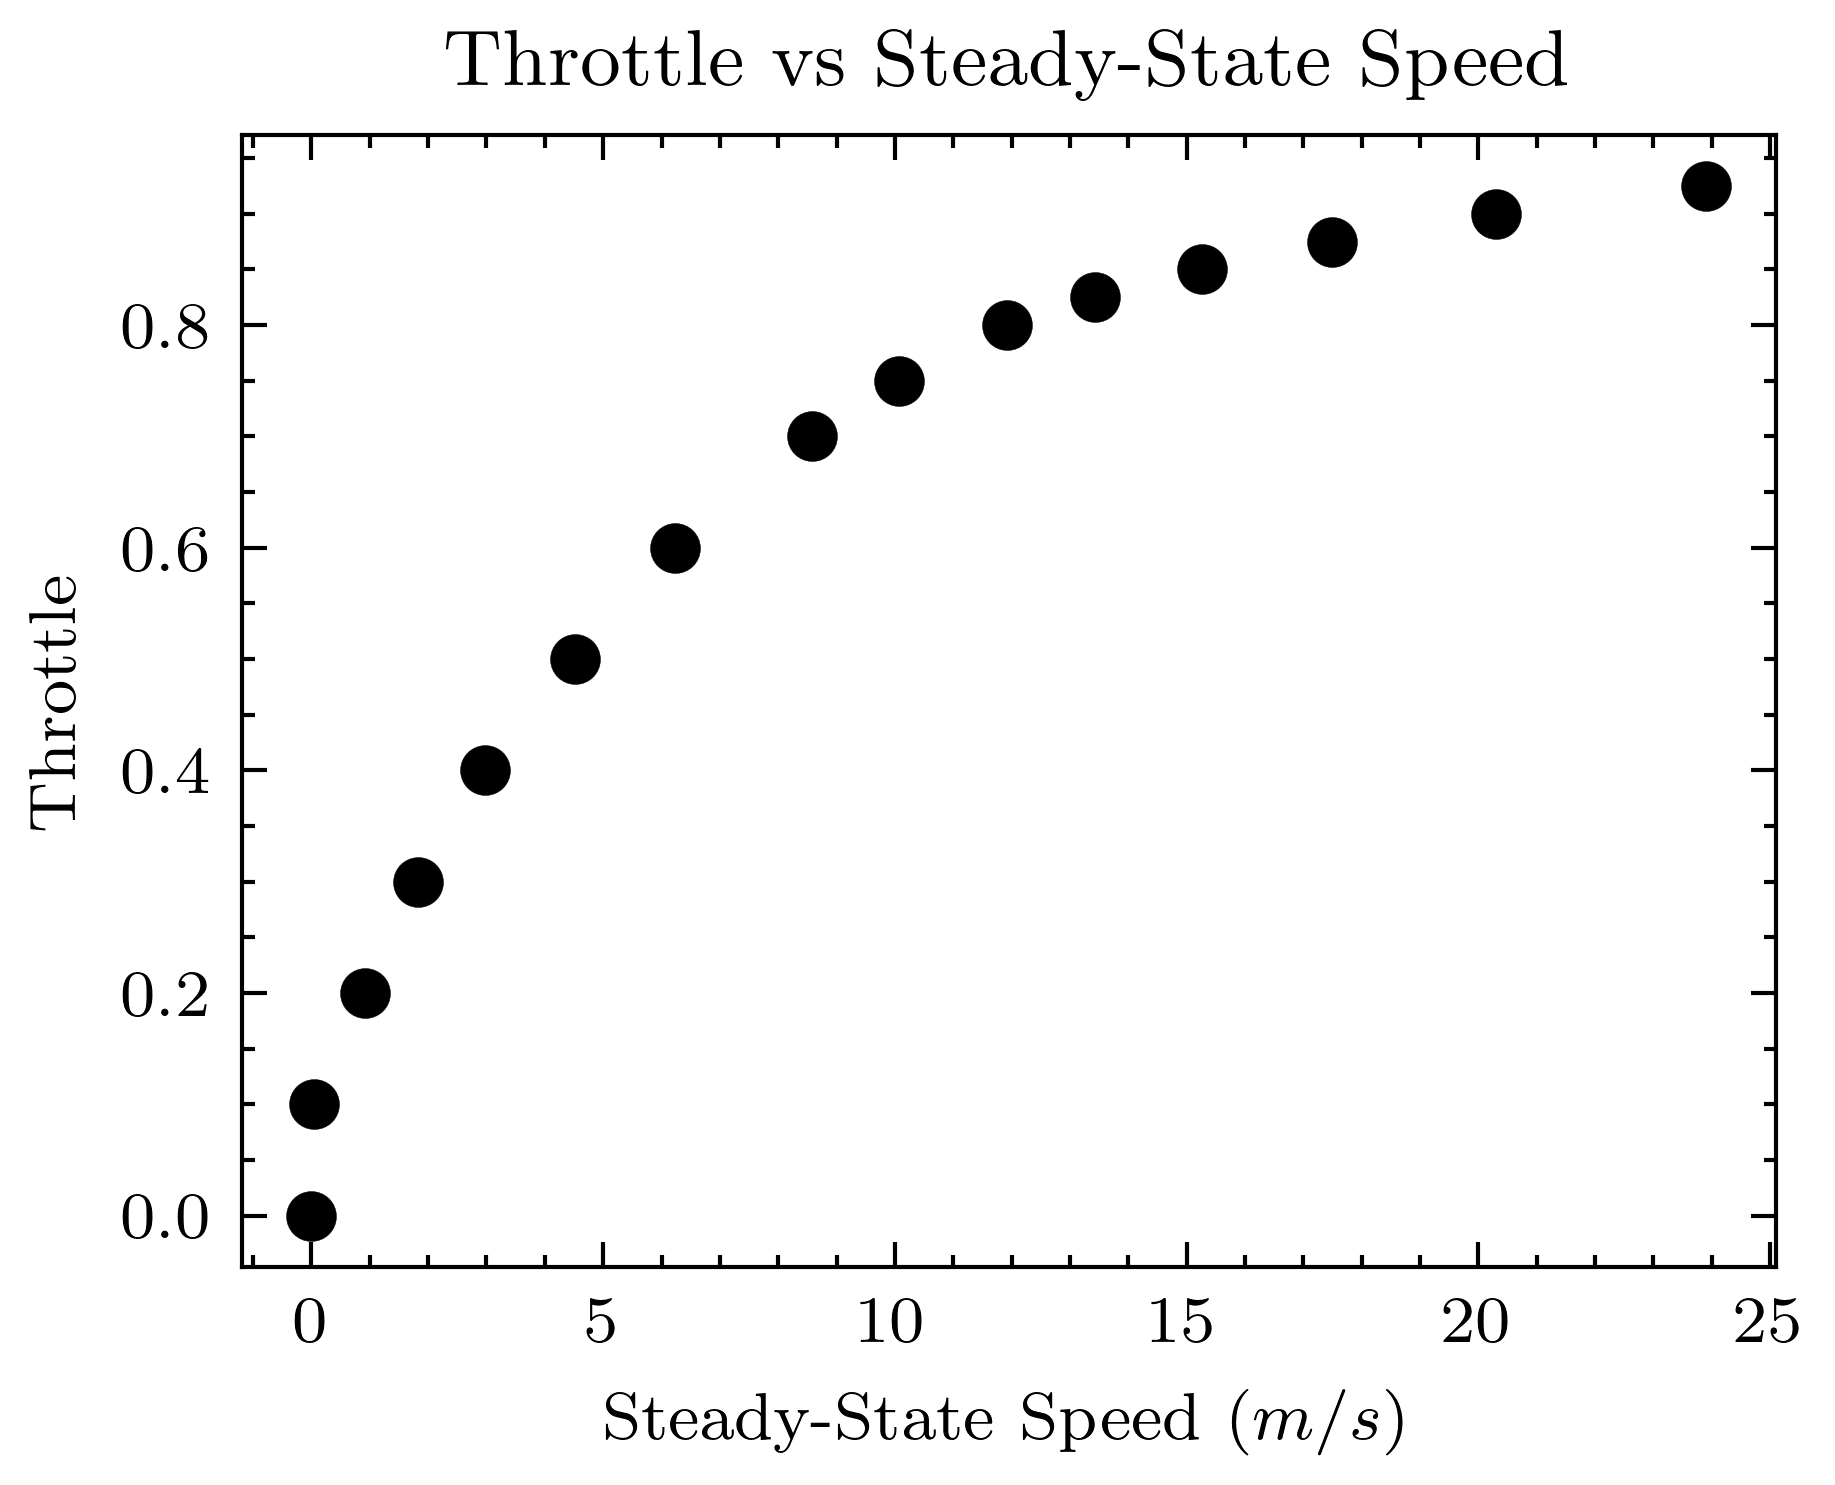

In [14]:
plt.scatter(v, u, linewidth=0.05)
plt.xlabel(r'Steady-State Speed $(m/s)$')
plt.ylabel('Throttle')
plt.title('Throttle vs Steady-State Speed')
plt.savefig('img/throttle_vs_speed', dpi=600, transparent=True, bbox_inches='tight',)
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


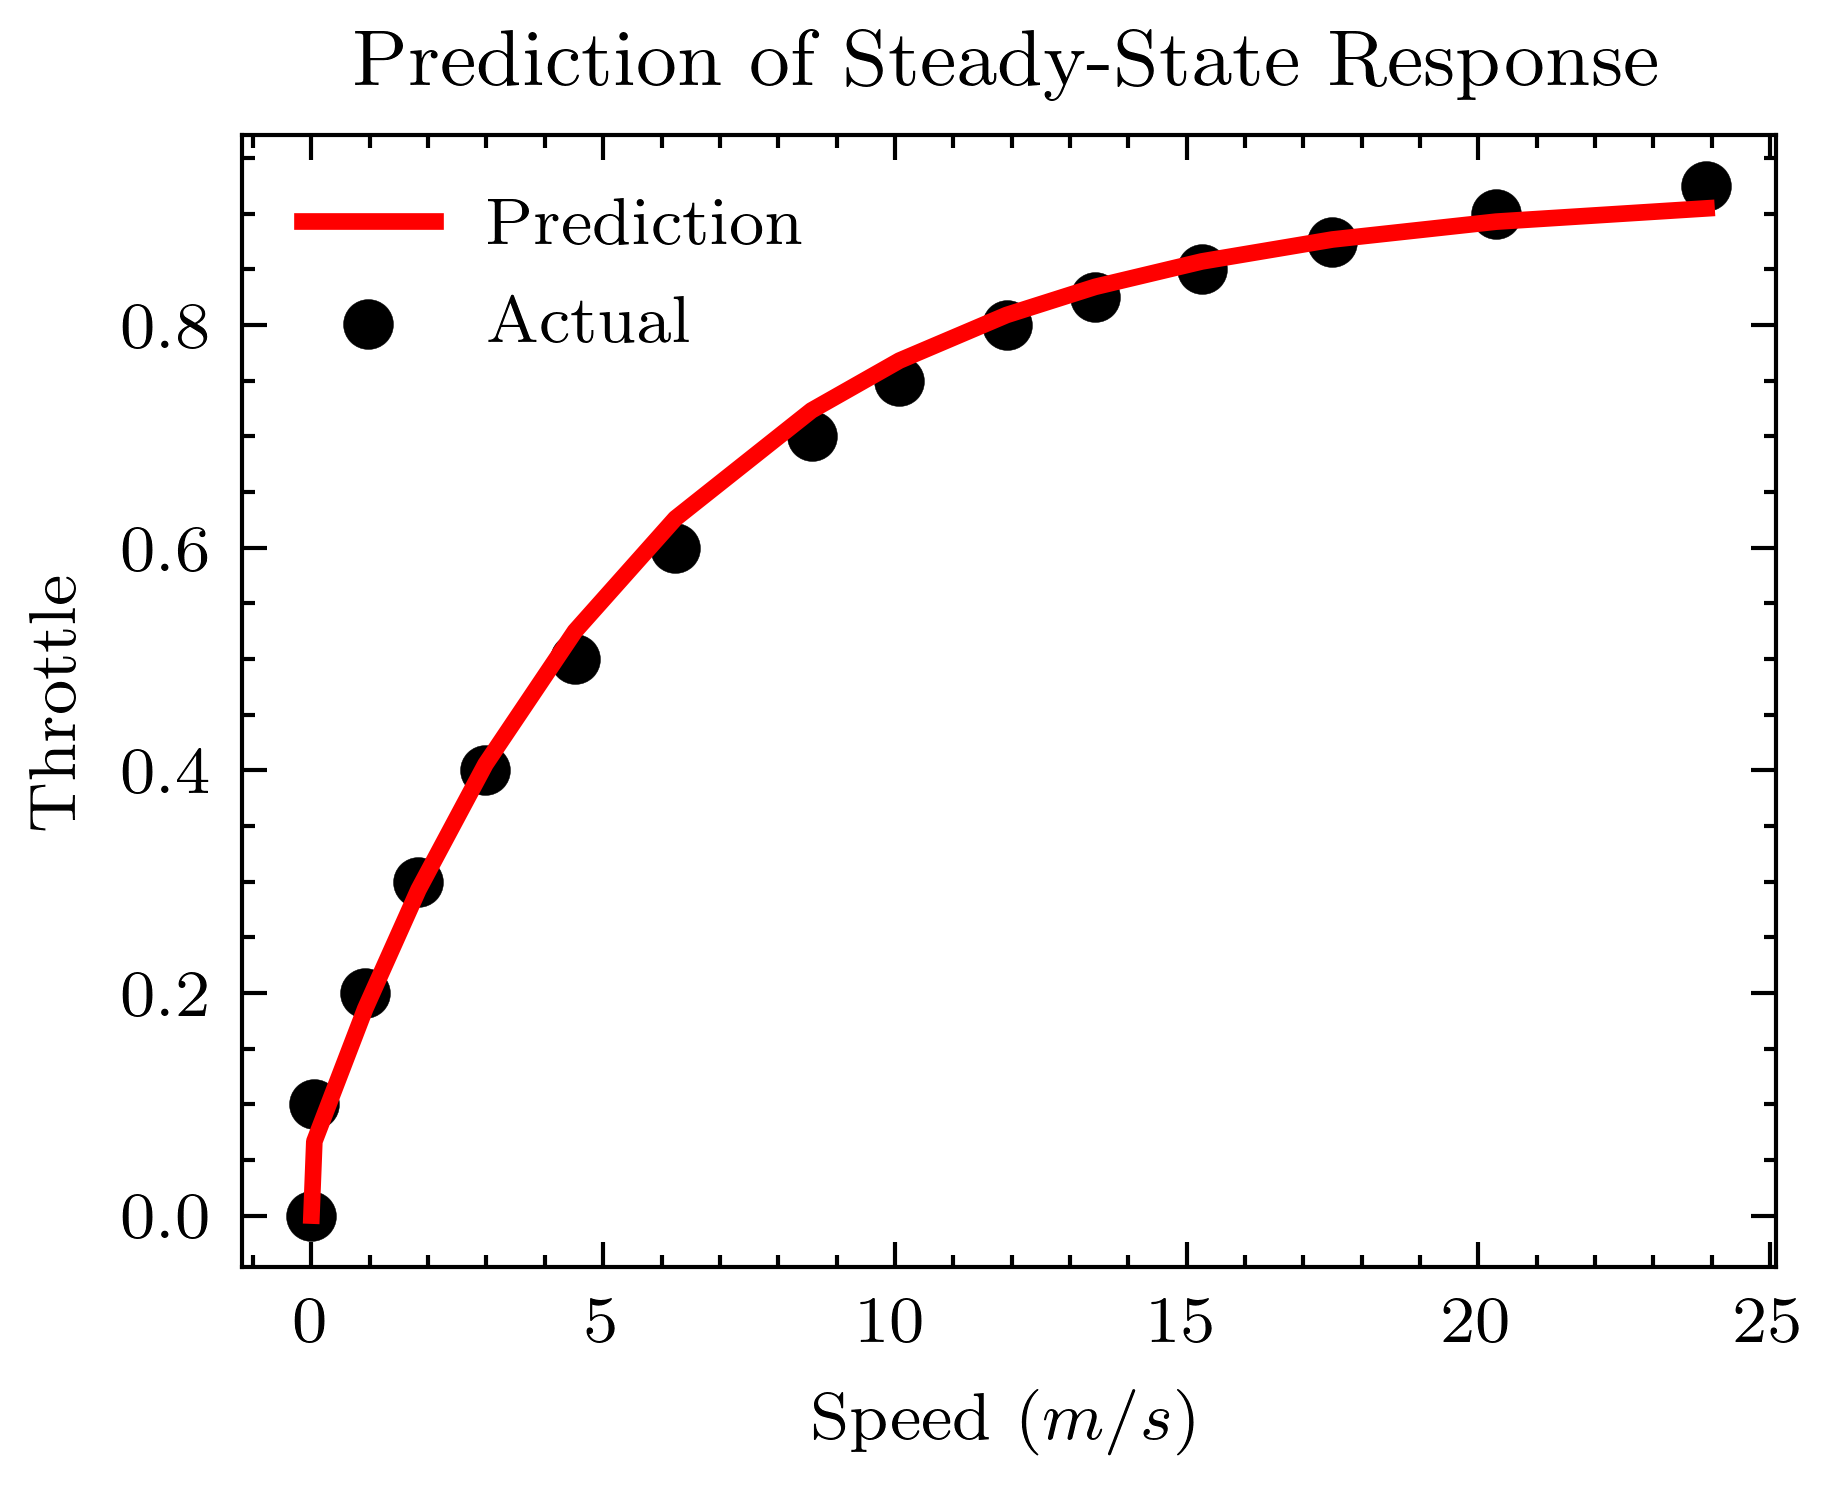

In [15]:
plt.scatter(v, u, label='Actual', linewidth=0.05)
plt.plot(v, forward_propagation(v, the_best_param_history[-1]), label='Prediction', color='red', linewidth=2)
plt.xlabel(r'Speed $(m/s)$')
plt.ylabel('Throttle')
plt.title('Prediction of Steady-State Response')
plt.legend()
plt.savefig('img/throttle_vs_speed_pred', dpi=600, transparent=True, bbox_inches='tight')
plt.show()